# Dependencies

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from random import sample
import lightgbm as lgb
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, recall_score, precision_score
import joblib

# Import Data

In [2]:
SEED = 42

In [3]:
fraud_df = pd.read_csv('https://assets-datascientest.s3-eu-west-1.amazonaws.com/de/total/fraud.csv',
                       parse_dates = ['signup_time','purchase_time'])

# Describe and find missing values

In [4]:
fraud_df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
is_fraud                   int64
dtype: object

In [5]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
#for column in fraud_df.columns:
#     print(column)
#    print(list(fraud_df[column].unique()))

In [6]:
fraud_df.isna().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
is_fraud          0
dtype: int64

In [7]:
graph_df = fraud_df.copy()

In [8]:
graph_df['purchase_date'] = graph_df['purchase_time'].dt.date

<AxesSubplot:xlabel='purchase_date'>

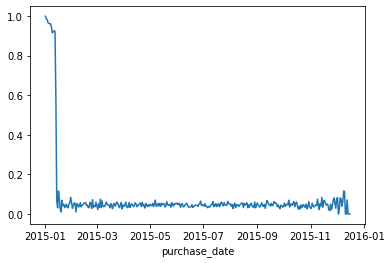

In [9]:
graph_df.groupby('purchase_date').apply(lambda x: sum(x['is_fraud']==1)/len(x)).plot()

# We data starting february as fraud rate is abnormally high in january 2015 (but the best strategy is to have two models: one before january 2015 and another after)

In [10]:
fraud_df = fraud_df[fraud_df['purchase_time']>'2015-02-01'].reset_index(drop=True)

# Undersampling data (to avoid model bias)

<AxesSubplot:>

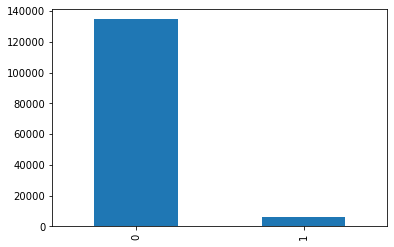

In [11]:
fraud_df['is_fraud'].value_counts().plot(kind='bar')

In [12]:
fraud_indexes = list(fraud_df[fraud_df['is_fraud'] == 1].index)
non_fraud_indexes = list(fraud_df[fraud_df['is_fraud'] == 0].index)

In [13]:
balanced_df_indexes = sample(non_fraud_indexes, len(fraud_indexes)) + fraud_indexes

In [14]:
balanced_fraud_df = fraud_df.iloc[balanced_df_indexes].reset_index(drop=True)

<AxesSubplot:>

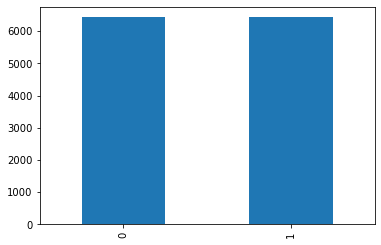

In [15]:
balanced_fraud_df['is_fraud'].value_counts().plot(kind='bar')

# Data Preprocessing

In [41]:
def process_df(original_df):
    df = original_df.copy()
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for cat_col in ['device_id','source','browser','sex']:
        cat_mapper = dict(zip(df[cat_col].unique(), range(1, len(df[cat_col].unique())+1)))
        df[cat_col] = df[cat_col].replace(cat_mapper)
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_semaine'] = df[f'{col_prefix}_time'].dt.dayofweek
        df[f'cos_{col_prefix}_semaine'] = np.cos(2.*np.pi*df[f'{col_prefix}_semaine']/7.)
        df[f'sin_{col_prefix}_semaine'] = np.sin(2.*np.pi*df[f'{col_prefix}_semaine']/7.)
        df = df.drop(columns=[f'{col_prefix}_time'])
    return df

In [42]:
processed_balanced_fraud_df = process_df(balanced_fraud_df)

In [43]:
processed_balanced_fraud_df.head()

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,is_fraud,delay_signup_purchase,...,sin_purchase_month,purchase_hour,cos_purchase_hour,sin_purchase_hour,purchase_minute,cos_purchase_minute,sin_purchase_minute,purchase_semaine,cos_purchase_semaine,sin_purchase_semaine
0,268319,43,1,1,1,1,38,1.738307e+08,0,40570,...,1.224647e-16,18,-1.836970e-16,-1.000000,33,-0.951057,-0.309017,2,-0.222521,0.974928
1,40278,9,2,1,2,1,32,3.817612e+09,0,30063,...,-8.660254e-01,16,-5.000000e-01,-0.866025,20,-0.500000,0.866025,6,0.623490,-0.781831
2,111175,89,3,1,2,1,25,3.366958e+09,0,66483,...,-5.000000e-01,14,-8.660254e-01,-0.500000,4,0.913545,0.406737,1,0.623490,0.781831
3,98635,17,4,2,3,1,28,3.415191e+09,0,68131,...,8.660254e-01,13,-9.659258e-01,-0.258819,42,-0.309017,-0.951057,6,0.623490,-0.781831
4,288466,30,5,2,3,2,22,2.717915e+09,0,84565,...,8.660254e-01,17,-2.588190e-01,-0.965926,24,-0.809017,0.587785,2,-0.222521,0.974928


# Split train test (ensure different users in each set train and test)

In [44]:
x_df = processed_balanced_fraud_df.loc[:, processed_balanced_fraud_df.columns != 'is_fraud'].reset_index(drop=True)
y_df = processed_balanced_fraud_df[['is_fraud']]

In [45]:
x_df.head(3)

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,delay_signup_purchase,signup_year,...,sin_purchase_month,purchase_hour,cos_purchase_hour,sin_purchase_hour,purchase_minute,cos_purchase_minute,sin_purchase_minute,purchase_semaine,cos_purchase_semaine,sin_purchase_semaine
0,268319,43,1,1,1,1,38,1.738307e+08,40570,2015,...,1.224647e-16,18,-1.836970e-16,-1.000000,33,-0.951057,-0.309017,2,-0.222521,0.974928
1,40278,9,2,1,2,1,32,3.817612e+09,30063,2015,...,-8.660254e-01,16,-5.000000e-01,-0.866025,20,-0.500000,0.866025,6,0.623490,-0.781831
2,111175,89,3,1,2,1,25,3.366958e+09,66483,2015,...,-5.000000e-01,14,-8.660254e-01,-0.500000,4,0.913545,0.406737,1,0.623490,0.781831


In [46]:
x_df.shape

(12856, 35)

In [47]:
y_df.head(3)

,is_fraud
0,0
1,0
2,0


In [48]:
y_df.shape

(12856, 1)

In [49]:
gs = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=SEED)

In [50]:
train_indexes, test_indexes = next(gs.split(x_df, y_df, groups=x_df.user_id))

x_train = x_df.iloc[train_indexes]
y_train = y_df.iloc[train_indexes]

x_test = x_df.iloc[test_indexes]
y_test = y_df.iloc[test_indexes]

# Train model on train data

In [51]:
clf = lgb.LGBMClassifier()

In [52]:
gridParams = {
    'learning_rate': [0.05],
    'num_leaves': [90,200],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'max_depth' : [5,6,7,8],
    'random_state' : [SEED], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.5,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
    'metric':['auc']
    }

In [54]:
grid = RandomizedSearchCV(clf, gridParams, verbose=1, cv=10, n_jobs = -1, n_iter=10)
grid.fit(x_train, y_train.values.ravel())

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.05],
                                        'max_depth': [5, 6, 7, 8],
                                        'metric': ['auc'],
                                        'min_data_in_leaf': [10],
                                        'min_split_gain': [0.01],
                                        'num_leaves': [90, 200],
                                        'objective': ['binary'],
                                        'random_state': [42],
                                        'subsample': [0.5, 0.7]},
                   verbose=1)

In [55]:
optimized_model = lgb.LGBMClassifier(**grid.best_params_)

# Variable selection

In [56]:
selector = RFE(optimized_model, step=1)
selector = selector.fit(x_train, y_train.values.ravel())

In [57]:
cols_to_keep = x_train.loc[:, selector.support_].columns

In [58]:
cols_to_keep

Index(['user_id', 'purchase_value', 'device_id', 'age', 'ip_address',
       'delay_signup_purchase', 'signup_hour', 'cos_signup_hour',
       'sin_signup_hour', 'signup_minute', 'cos_signup_minute',
       'sin_signup_minute', 'purchase_month', 'purchase_hour',
       'purchase_minute', 'cos_purchase_minute', 'sin_purchase_minute'],
      dtype='object')

In [59]:
more_optimized_model = lgb.LGBMClassifier(**grid.best_params_)
more_optimized_model.fit(x_train[cols_to_keep], y_train.values.ravel())

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.05, max_depth=7,
               metric='auc', min_data_in_leaf=10, min_split_gain=0.01,
               num_leaves=90, objective='binary', random_state=42,
               subsample=0.7)

# Discover variables importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

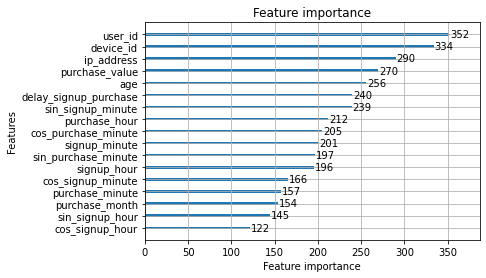

In [60]:
lgb.plot_importance(more_optimized_model)

# Test on test set

In [61]:
y_pred = more_optimized_model.predict(x_test[cols_to_keep])

In [62]:
f1_score(y_test.values.ravel(), y_pred)

0.9933980582524272

In [63]:
recall_score(y_test.values.ravel(), y_pred)

0.9884080370942813

In [64]:
precision_score(y_test.values.ravel(), y_pred)

0.9984387197501952

# Final preprocessing_function for further use on new data

In [65]:
def process_df(original_df):
    df = original_df.copy()
    df['delay_signup_purchase'] = (df['signup_time'] - df['purchase_time']).dt.seconds
    for cat_col in ['device_id','source','browser','sex']:
        cat_mapper = dict(zip(df[cat_col].unique(), range(1, len(df[cat_col].unique())+1)))
        df[cat_col] = df[cat_col].replace(cat_mapper)
    for col_prefix in ['signup', 'purchase']:
        df[f'{col_prefix}_year'] = df[f'{col_prefix}_time'].dt.year
        df[f'{col_prefix}_month'] = df[f'{col_prefix}_time'].dt.month
        df[f'cos_{col_prefix}_month'] = np.cos(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'sin_{col_prefix}_month'] = np.sin(2.*np.pi*df[f'{col_prefix}_month']/12.)
        df[f'{col_prefix}_hour'] = df[f'{col_prefix}_time'].dt.hour
        df[f'cos_{col_prefix}_hour'] = np.cos(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'sin_{col_prefix}_hour'] = np.sin(2.*np.pi*df[f'{col_prefix}_hour']/24.)
        df[f'{col_prefix}_minute'] = df[f'{col_prefix}_time'].dt.minute
        df[f'cos_{col_prefix}_minute'] = np.cos(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'sin_{col_prefix}_minute'] = np.sin(2.*np.pi*df[f'{col_prefix}_minute']/60.)
        df[f'{col_prefix}_semaine'] = df[f'{col_prefix}_time'].dt.dayofweek
        df[f'cos_{col_prefix}_semaine'] = np.cos(2.*np.pi*df[f'{col_prefix}_semaine']/7.)
        df[f'sin_{col_prefix}_semaine'] = np.sin(2.*np.pi*df[f'{col_prefix}_semaine']/7.)
        df = df.drop(columns=[f'{col_prefix}_time'])
    df = df[['user_id', 'purchase_value', 'device_id', 'age', 'ip_address',
             'delay_signup_purchase', 'signup_month', 'signup_hour', 'signup_minute',
             'sin_signup_minute', 'cos_purchase_hour', 'sin_purchase_hour',
             'purchase_minute', 'cos_purchase_minute']]
    return df

# Saving trained model for further use

In [66]:
joblib.dump(more_optimized_model, 'fraud_lgb.pkl')
gbm_pickle = joblib.load('fraud_lgb.pkl')